In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from src.model.full_model import SubCellProtModel
from src.utils.analysis_utils import call_model
import numpy as np
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os
import umap
from sklearn.manifold import TSNE
import pickle

In [2]:
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    batch_size=32,
)

In [13]:
from pymongo import MongoClient
from src.utils.utils import get_data_path
import pickle 

COLLECTION_NAME = "splice_isoforms"
if os.path.exists('cell_line_activation.pkl'):
    new_activation_roundup_df = pd.read_pickle("cell_line_activation.pkl") 
else:
    new_activation_roundup_df= pd.DataFrame()

num_cell_images_per_cell_line_in_proteoform = 5
limit = 23000

save_cadence = 300
rest_cadence = 100

In [14]:
import time
import random
from random import sample 

with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]
    cursor = dataset_collection.find()

    for idx, document in tqdm(enumerate(cursor)):
        if idx % rest_cadence == 0:
            time.sleep(0.1)

        if len(new_activation_roundup_df) > 0 and document["_id"] in new_activation_roundup_df["Proteoform"]:
            continue

        try:
            X_esm2_encoding = pickle.loads(document["esm2_representation"]["binary"])
            X_protein_len = document["length"]
            localization_labels = document["cell_lines"][0]["antibodies"][0][
                "location_labels"
            ]["locations"]
            localization_labels = localization_labels.split(",")
            for cell_line in document["cell_lines"]:
                landmark_stains = []
                for antibody in cell_line["antibodies"]:
                    for image_url in antibody['image_urls']:
                        for cell_image in image_url["cell_images"]:
                            landmark_stains.append(
                                np.stack(
                                    (
                                        np.array(
                                            Image.open(
                                                get_data_path(
                                                    cell_image["nuclei_channel"]
                                                )
                                            )
                                        ),
                                        np.array(
                                            Image.open(
                                                get_data_path(
                                                    cell_image["microtubule_channel"]
                                                )
                                            )
                                        ),
                                        np.array(
                                            Image.open(
                                                get_data_path(
                                                    cell_image["mitochondria_channel"]
                                                )
                                            )
                                        ),
                                    )
                                )
                            )
                
                random.seed(5)
                for X_landmark_stains in sample(landmark_stains, num_cell_images_per_cell_line_in_proteoform):
                    _y_pred_ranked, _y_pred_antibody_stain, activation = call_model(
                        loaded_model,
                        X_esm2_encoding,
                        X_protein_len,
                        X_landmark_stains,
                        embedding_hooks=["cell_embedding"],
                    )
                    new_activation_roundup_df = new_activation_roundup_df._append(
                        {
                            "Proteoform": document["_id"],
                            "Activation": np.array(activation["cell_embedding"]).flatten(),
                            "Localization": localization_labels,
                            "Cell Line": cell_line['name'],
                        },
                        ignore_index=True,
                    )
                    if limit % save_cadence == 0:
                        new_activation_roundup_df.to_pickle("cell_line_activation.pkl")  
                        print("saved!: ", limit)  
                        time.sleep(0.5)

                    limit -= 1
                    if limit <= 0:
                        break
        except:
            continue

new_activation_roundup_df.to_pickle("cell_line_activation.pkl")  


13it [00:03,  7.24it/s]

saved!:  99900


157it [00:15,  8.19it/s]

saved!:  99600


210it [00:23,  7.74it/s]

In [18]:
import pandas as pd
new_activation_roundup_df = pd.read_pickle("cell_line_activation.pkl")  

new_activation_roundup_df

,Proteoform,Activation,Localization,Cell Line
0,TSPAN6-201,"[-0.9732482, 0.13280354, 0.06364124, -0.972187...","[Cell Junctions, Cytosol, Nucleoli fibrillar c...",RT4
1,TSPAN6-201,"[0.6215077, 1.8113884, -0.6956379, 0.21477225,...","[Cell Junctions, Cytosol, Nucleoli fibrillar c...",RT4
2,TSPAN6-201,"[0.024609247, 0.4268044, -0.8218333, -0.659952...","[Cell Junctions, Cytosol, Nucleoli fibrillar c...",RT4
3,TSPAN6-201,"[-0.5440987, -0.034004055, 0.12101765, 1.07042...","[Cell Junctions, Cytosol, Nucleoli fibrillar c...",RT4
4,TSPAN6-201,"[0.23056775, 0.95830846, -0.7444091, -0.975060...","[Cell Junctions, Cytosol, Nucleoli fibrillar c...",RT4
...,...,...,...,...
22997,POLR3H-204,"[-0.981037, -0.980943, -0.9806694, -0.9807822,...","[Centrosome, Nucleoplasm]",U2OS
22998,POLR3H-204,"[0.9532833, 0.22454199, 0.33989245, -0.500714,...","[Centrosome, Nucleoplasm]",U2OS
22999,POLR3H-204,"[-0.65604305, -0.38347286, 0.7371401, 0.635667...","[Centrosome, Nucleoplasm]",U2OS
23000,POLR3H-204,"[-0.9732335, -0.9757124, -0.974651, -0.9752703...","[Centrosome, Nucleoplasm]",U2OS


In [19]:
import numpy as np
subsampled_activation_roundup_df = new_activation_roundup_df.sample(n=3000, random_state=42)
subsampled_cell_line_data = np.array([np.array(np.squeeze(x)) for x in subsampled_activation_roundup_df['Activation'].to_numpy()])
full_cell_line_data = np.array([np.array(np.squeeze(x)) for x in new_activation_roundup_df['Activation'].to_numpy()])
print(subsampled_cell_line_data.shape, full_cell_line_data.shape)

(3000, 131072) (23002, 131072)


In [ ]:
import umap

umap_learner = umap.UMAP(n_components=2, )
umap_learner.fit(
    subsampled_cell_line_data
)
umap_results = umap_learner.transform(full_cell_line_data)

new_activation_roundup_df["UMAP 1"] = umap_results[:, 0]
new_activation_roundup_df["UMAP 2"] = umap_results[:, 1]

In [32]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100)
# Fit PCA with a subset of 3000 samples and then project the full dataset
pca.fit(subsampled_cell_line_data)
pca_results = pca.transform(full_cell_line_data)
print("PCA explained variances:", pca.explained_variance_ratio_)
print("PCA explained variance sum: ", sum(pca.explained_variance_ratio_))

new_activation_roundup_df['PC 1'] = pca_results[:, 1]
new_activation_roundup_df['PC 2'] = pca_results[:, 2]

PCA explained variances: [0.02911049 0.02255888 0.01716685 0.01517018 0.01019593 0.00881431
 0.00820655 0.00799831 0.00743571 0.00681963 0.00668431 0.00599191
 0.00537596 0.00515186 0.00465018 0.0045941  0.00438083 0.0042325
 0.00402546 0.00399207 0.00384984 0.00354873 0.00349068 0.00346676
 0.00330429 0.00320551 0.00305169 0.00300561 0.00292907 0.00282069
 0.00275545 0.00267347 0.00265421 0.0025901  0.00255385 0.00244739
 0.00243793 0.00237949 0.00234633 0.00232634 0.00223319 0.00220738
 0.00218257 0.00209681 0.00208907 0.00207105 0.0020387  0.00199055
 0.00196813 0.00195973 0.00190381 0.00186503 0.00183828 0.00180905
 0.00177824 0.00176547 0.00175272 0.00172569 0.00170075 0.00167914
 0.00165339 0.00162956 0.00161944 0.00161436 0.0015919  0.00158042
 0.00156028 0.00154506 0.00153568 0.00152049 0.00149837 0.00148606
 0.00145428 0.0014326  0.00142956 0.0014235  0.00141445 0.00138923
 0.00137091 0.00135941 0.0013447  0.00132425 0.00131343 0.00131018
 0.00130628 0.00130191 0.00128546 0.00

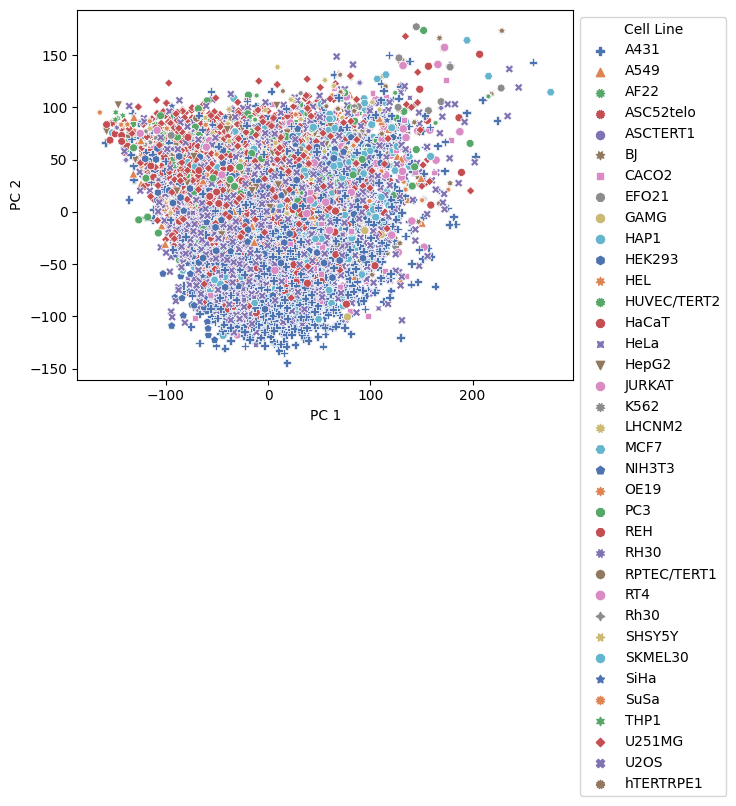

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt


def dedup_cell_line_names(cell_line_name):
    lookup = {
        "BJ[Humanfibroblast]": "BJ",
        "HUVECTERT2": "HUVEC/TERT2",
        "RPTECTERT1": "RPTEC/TERT1",
        "hTERTRPE1(serumstarved)": "hTERTRPE1",
    }
    return lookup.get(cell_line_name, cell_line_name)


new_activation_roundup_df["Cell Line"] = new_activation_roundup_df["Cell Line"].apply(
    dedup_cell_line_names
)
hue_order = sorted(list(set(new_activation_roundup_df["Cell Line"])))
f = plt.figure()

ax = sns.scatterplot(
    data=new_activation_roundup_df,
    x="PC 1",
    y="PC 2",
    style="Cell Line",
    hue="Cell Line",
    hue_order=hue_order,
    palette='deep',
    # alpha=0.5,
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
f.savefig("all_cell_line_pca.pdf", bbox_inches='tight')

plt.show()

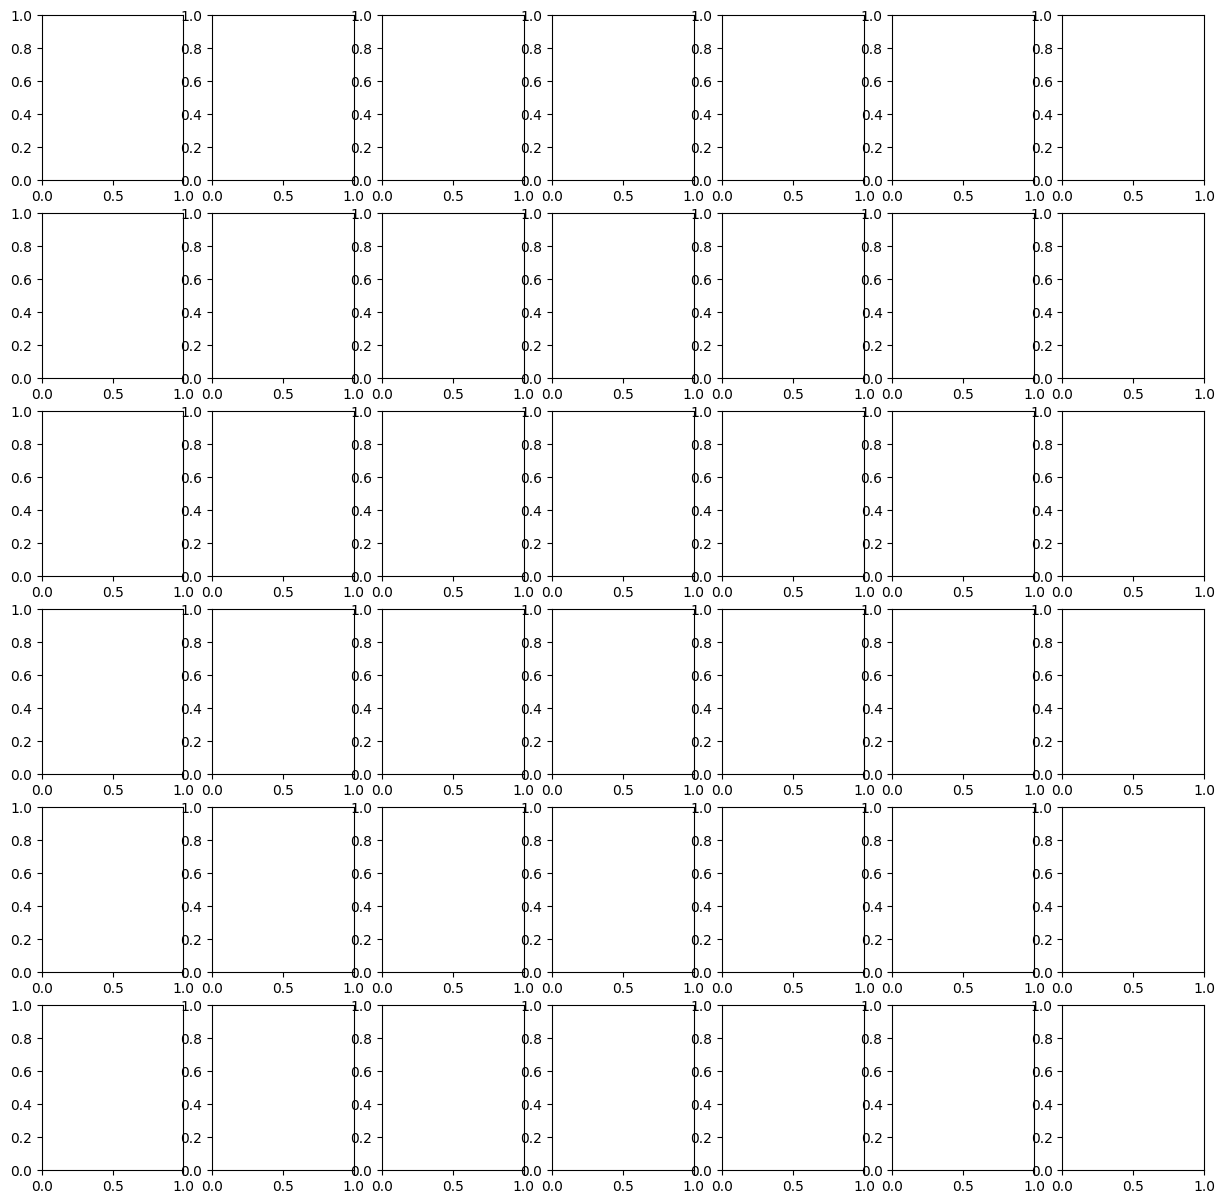

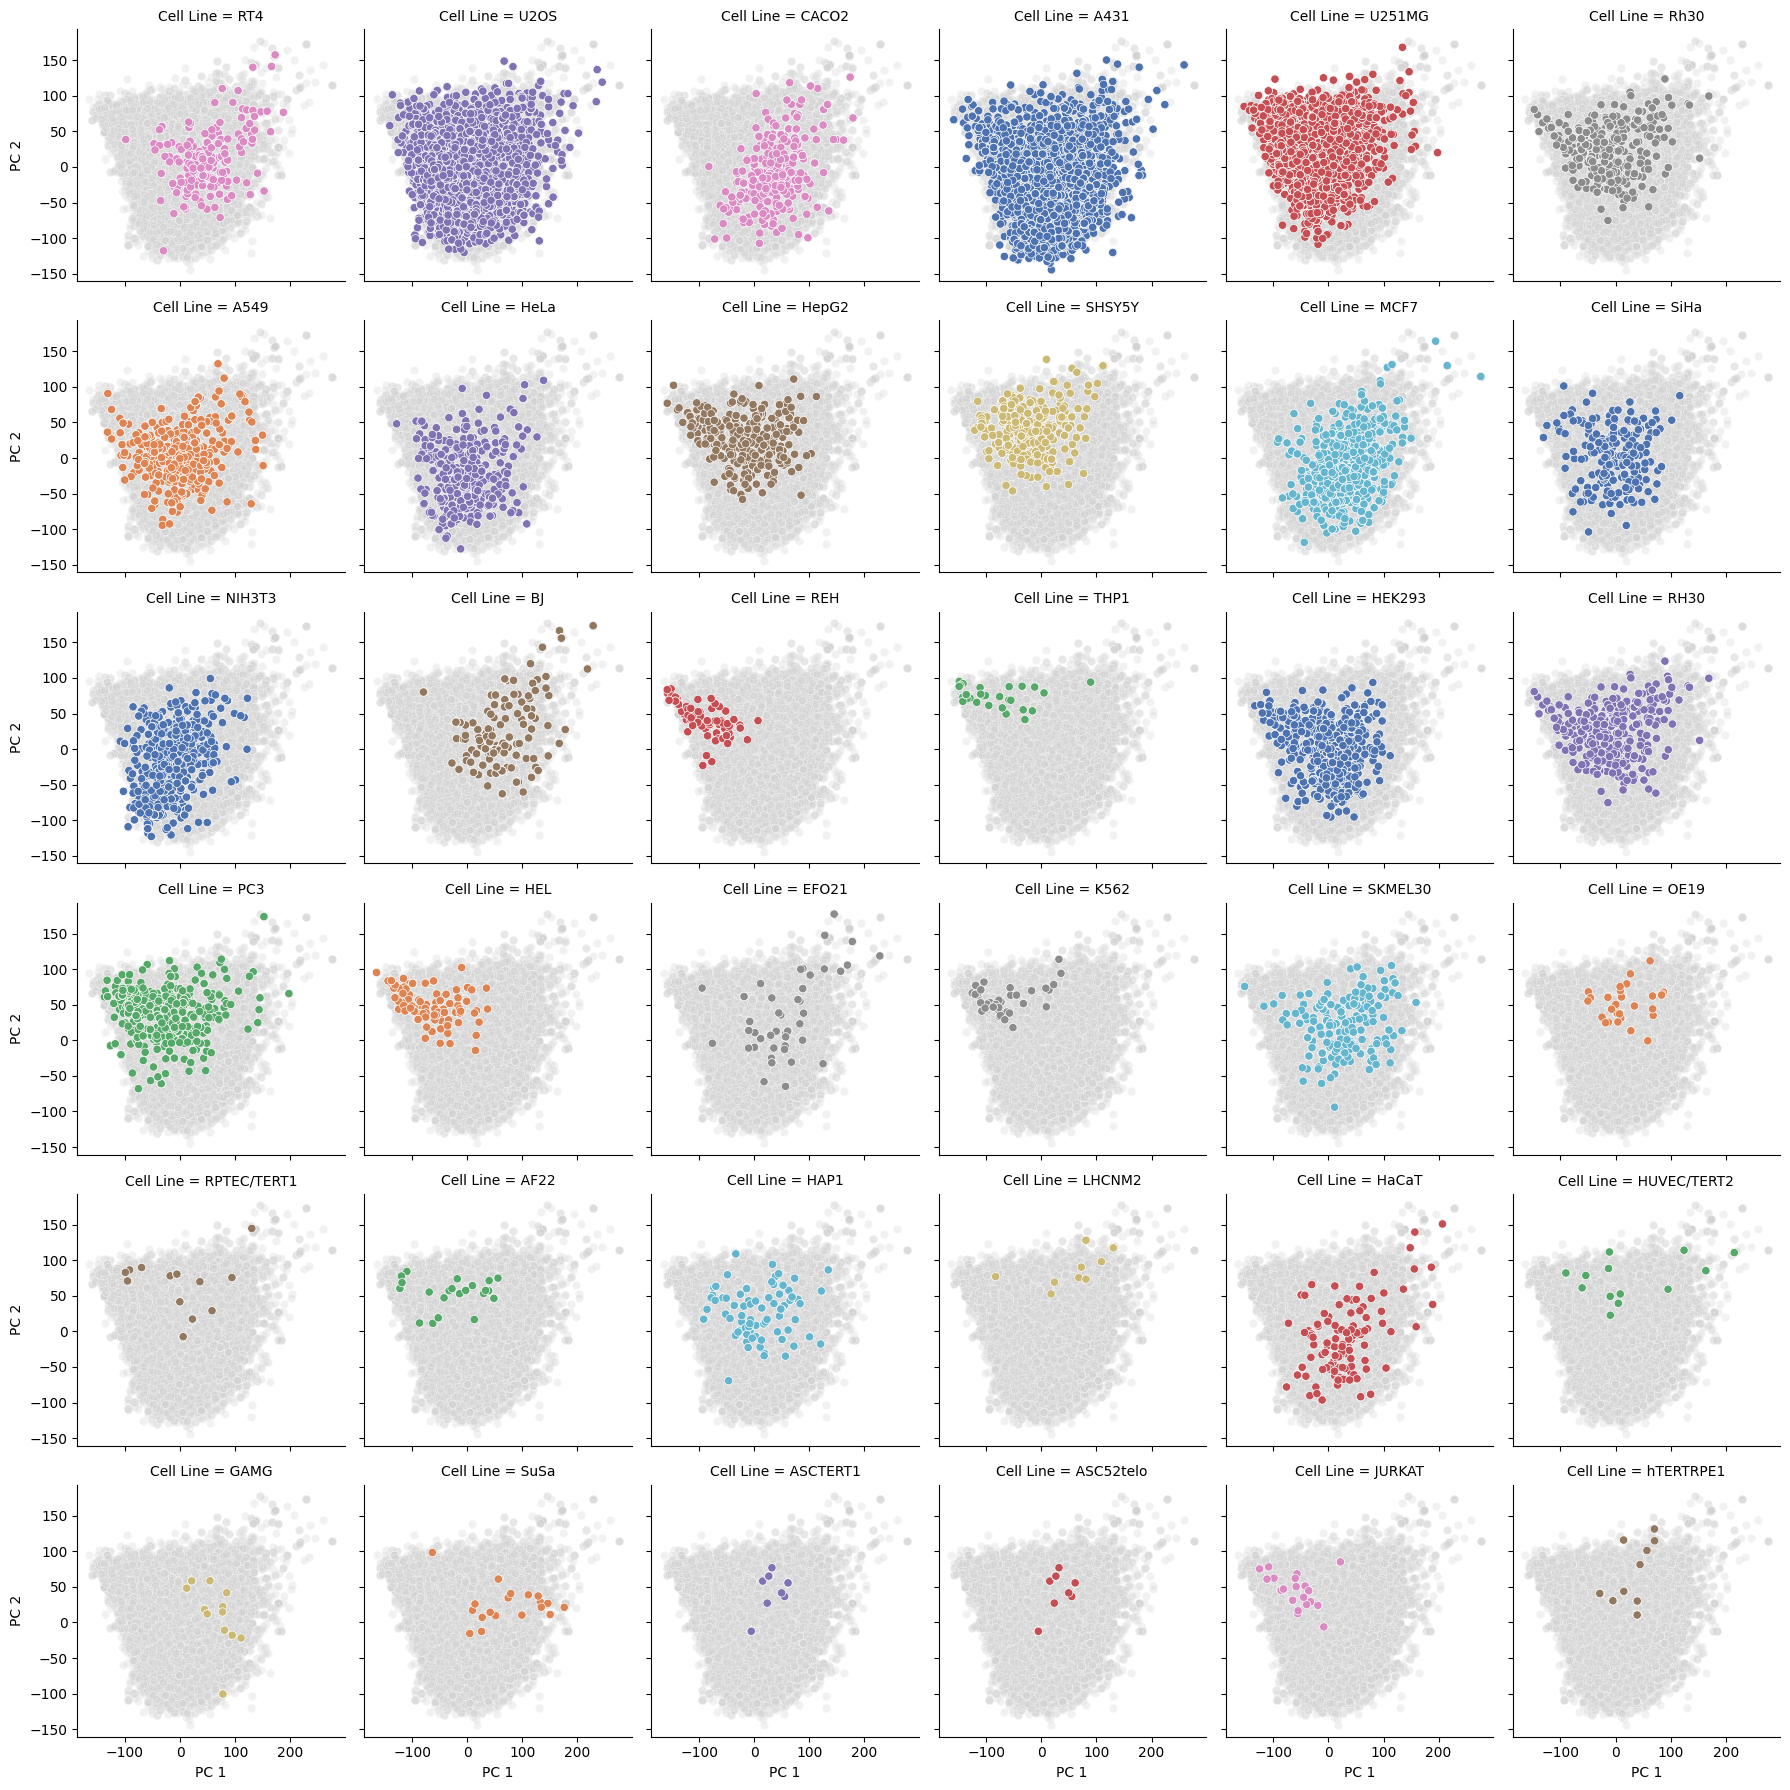

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

f, axes = plt.subplots(6, 7, figsize=(15, 15)) 

g = sns.FacetGrid(
    new_activation_roundup_df, 
    col='Cell Line', 
    col_wrap=6,
)

def plot_grey_background(data, color, **kwargs):
    sns.scatterplot(
        x='PC 1',
        y='PC 2',
        data=new_activation_roundup_df,
        color='lightgrey',  
        ax=plt.gca(), 
        alpha=0.3, 
    )

g.map_dataframe(plot_grey_background)

g.map_dataframe(
    sns.scatterplot,
    x='PC 1',
    y='PC 2',
    hue='Cell Line',
    style='Cell Line',
    palette='deep',
    hue_order=hue_order,
    ax=plt.gca()
)

plt.tight_layout()

g.savefig("all_proteoform_pca_exploded.pdf", bbox_inches='tight')

plt.show()
